In [16]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# download mnist_dataset to desired directory and split to train, val, test
from make_modular.configs import TRAIN_DATASET_PATH, TEST_DATASET_PATH
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_ds = MNIST(TRAIN_DATASET_PATH, train=True, download=True, transform=transform)
test_ds = MNIST(TEST_DATASET_PATH, train=False, download=True, transform=transform)

# split train_dataset to train and validation dataset
val_percent = .15
val_size = int(val_percent * len(train_ds))
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [3]:
# test our datasets
len(train_ds), len(val_ds), len(test_ds)

(51000, 9000, 10000)

In [4]:
# make dataLoaders 
from make_modular.configs import batch_size

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [5]:
# test dataloaders
images, labels = next(iter(train_dl))

In [6]:
# convert image_tesnsor: (b, c, h, w) --> numpy_array: (b, h, w, c)=(b, 28, 28, 1)
# img = images.numpy().transpose(0, 2, 3, 1)
# plt.imshow(img[0])

In [7]:
# show some images of dataset
from make_modular.utils import show_images
# show_images(images, labels)

In [8]:
# model
class MODEL_1(nn.Module):
    def __init__(self, in_channel=1, num_classes=10) -> None:
        super().__init__()

        self.cnn = nn.Sequential(
            # W_out ((w_in - kernel_size + 2p)/stride) +1
            nn.Conv2d(in_channels=in_channel, out_channels=32, kernel_size=3), # (b, 1, 28, 28) --> (b, 32, 26, 26)
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # (b, 32, 26, 26) --> (b, 64, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (b, 64, 24, 24) --> (b, 64, 12, 12)
            nn.Dropout(.5),
            nn.Flatten() # (b, 64, 12, 12) --> (b, 64*12*12)
        )

        self.fc = nn.Sequential(
            nn.Linear(in_features=64*12*12, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
            )

    def forward(self, x):
        out = self.cnn(x)
        out = self.fc(out)
        # print(out.shape)
        return out

        # self.fc = nn.Linear

In [9]:
model = MODEL_1()
input = torch.randn(4, 1, 28, 28)
output = model(input)
print(output.shape)

torch.Size([4, 10])


In [50]:
from make_modular.engine import train

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MODEL_1()

lr = 3e-4
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

results = train(model=model,
                train_dl=train_dl,
                val_dl=val_dl,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                epochs=5)

train_loss:0.21 | val_loss:0.08 | train_acc:0.94 | val_acc:0.97 | train_f1_score:0.94 | val_f1_score:0.97
train_loss:0.07 | val_loss:0.05 | train_acc:0.98 | val_acc:0.98 | train_f1_score:0.98 | val_f1_score:0.98
train_loss:0.05 | val_loss:0.04 | train_acc:0.99 | val_acc:0.99 | train_f1_score:0.98 | val_f1_score:0.99
train_loss:0.04 | val_loss:0.04 | train_acc:0.99 | val_acc:0.99 | train_f1_score:0.99 | val_f1_score:0.99
train_loss:0.03 | val_loss:0.04 | train_acc:0.99 | val_acc:0.99 | train_f1_score:0.99 | val_f1_score:0.99


In [11]:
# results

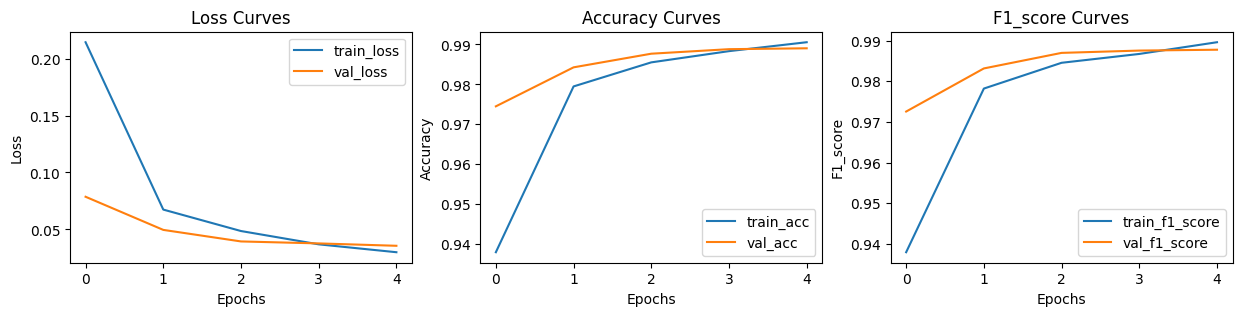

In [52]:
from make_modular.utils import plot_loss_curves
plot_loss_curves(results=results)

In [12]:
# use data augmentation
# draw some models